# Tag Generator

This notebook generates tags as recommendation for questions using a classifier trained on the [academia.stackexchange.com](https://academia.stackexchange.com/).

## Table of Contents
* [Data Import](#data_import)
* [Best Classifier](#best_classifier)
* [Quantitative Evaluation](#quantitative)
* [Qualitative Evaluation](#qualitative)

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from joblib import load

warnings.filterwarnings('ignore')
plt.style.use('plotstyle.mplstyle')
plt.rcParams.update({
    'axes.grid.axis': 'y',
    'figure.figsize': (12, 8),
    'font.size': 18,
    'lines.linewidth': 1,
    'lines.marker': 'None'
})

<a id='data_import'/>

## Data Import

In [2]:
from academia_tag_recommender.experiments.experimental_classifier import available_classifier_paths
from academia_tag_recommender.experiments.data import ExperimentalData
ed = ExperimentalData.load()
_, X_test, _, y_test = ed.get_train_test_set()
labels = ed.label

<a id='best_classifier'/>

## Best Classifier

In [3]:
paths = available_classifier_paths()
best = [0, '']
for path in paths:
    clf = load(path)
    recall = clf.evaluation.recall_macro
    if recall > best[0]:
        best = [recall, path]

In [4]:
name, transformer, *rest = re.findall(r'=([\w,\d,\-()]*)', str(best[1]))
print('Best classifier: {}, using transformer: {} with recall: {}'.format(name, transformer, best[0]))
classifier = load(best[1])

Best classifier: ClasswiseClassifier(multiple)-gridsearch-undersample, using transformer: count with recall: 0.4811631767124024


Only tags with more than 70 samples were used as data for the classifiers. Therefore only the following tags can be assigned by the classifier.

In [5]:
print('The following {} labels can be assigned:'.format(len(labels)))
print(sorted(labels))

The following 190 labels can be assigned:
['abstract', 'academic-history', 'academic-life', 'acknowledgement', 'administration', 'advisor', 'affiliation', 'anonymity', 'answering-questions', 'application', 'application-cover-letter', 'arxiv', 'assistant-professor', 'australia', 'authorship', 'awards', 'bachelor', 'bibliometrics', 'biology', 'books', 'canada', 'career-path', 'changing-fields', 'cheating', 'citation-style', 'citations', 'code', 'collaboration', 'communication', 'computer-science', 'conference', 'conflict-of-interest', 'copyright', 'coursework', 'covid-19', 'cv', 'data', 'deadlines', 'defense', 'degree', 'disability', 'disreputable-publishers', 'early-career', 'economics', 'editors', 'education', 'elsevier', 'email', 'emotional-responses', 'engineering', 'errors-erratum', 'ethics', 'etiquette', 'europe', 'evaluation', 'exams', 'faculty-application', 'feedback', 'fees', 'formatting', 'funding', 'gender', 'germany', 'google-scholar', 'gpa', 'grades', 'grading', 'graduate-ad

In [6]:
clf_paths = classifier.classifier._clfs
types = {'MLPClassifier': 0, 
         'LinearSVC': 0, 
         'LogisticRegression': 0}

for clf in clf_paths:
    clf_ = load(clf)
    types[type(clf_).__name__] += 1
    
print('The best classifier uses the following baseclassifiers: ', types)

The best classifier uses the following baseclassifiers:  {'MLPClassifier': 75, 'LinearSVC': 100, 'LogisticRegression': 15}


<a id='quantitative'/>

## Quantitative Evaluation

For the quantitative evaluation of the classifier we predict labels for the test data set and compare them to the original labels.
Doing that over the whole data set we calculate metrics to evaluate.

In [7]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray()
    l = 1 - np.absolute(orig - prediction)
    return np.average(l, axis=0)

In [8]:
def per_label_balanced_accuracy(orig, prediction):
    labelwise_orig = np.transpose(orig)
    labelwise_pred = np.transpose(prediction)
    label_accuracies = []
    for label_index, label_orig in enumerate(labelwise_orig):
        label_pred = labelwise_pred[label_index]
        pos_indexes = [i for i, val in enumerate(label_orig) if val]
        neg_indexes = [i for i, val in enumerate(label_orig) if not val]
        min_n_samples = min(len(pos_indexes), len(neg_indexes))
        indexes = pos_indexes[0:min_n_samples] + neg_indexes[0:min_n_samples]
        label_accuracy = np.average(1 - np.absolute(label_orig[indexes] - label_pred[indexes]))
        label_accuracies.append(label_accuracy)
    return label_accuracies

In [9]:
from sklearn.metrics import classification_report
test = classifier.transform(X_test)
prediction = classifier.predict(test)
label_accuracies = per_label_accuracy(y_test, prediction)
balanced_label_accuracies = per_label_balanced_accuracy(y_test, prediction)
report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
classwise_report = {}
for i, result in enumerate(report):
    if i < len(label_accuracies):
        classwise_report[result] = report[result]
        classwise_report[result]['accuracy'] = label_accuracies[int(result)]
        classwise_report[result]['balanced_accuracy'] = balanced_label_accuracies[int(result)]

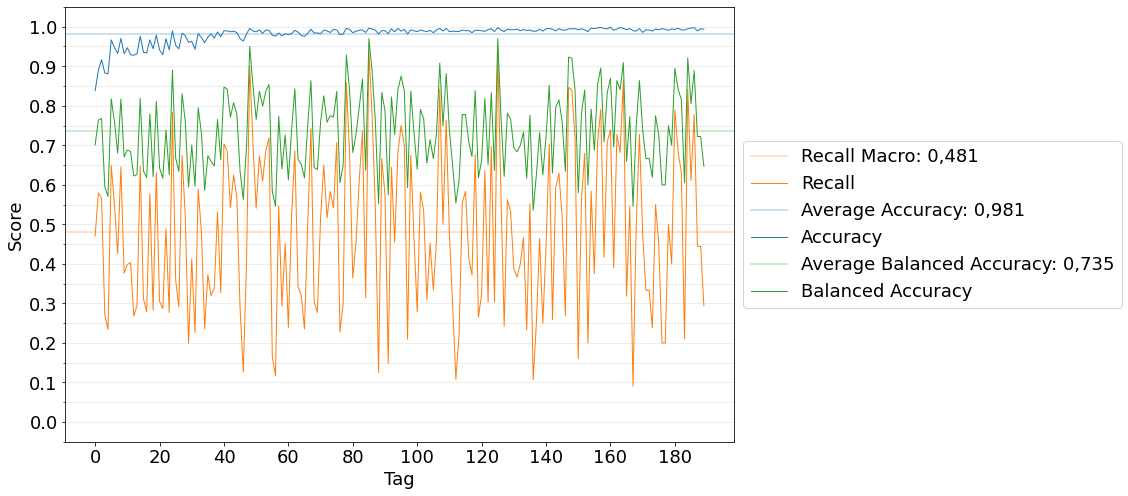

In [10]:
x_ = np.arange(0, len(y_test[0]))
container, fig = plt.subplots()
sorted_results = sorted(classwise_report, key=lambda x: classwise_report[x]['support'], reverse=True)
recall_macro = np.average([classwise_report[result]['recall'] for result in sorted_results][0:len(x_)])
fig.axhline(y=recall_macro, linewidth=1.5, color='tab:orange', alpha=0.3, label='Recall Macro: {:.3}'.format(recall_macro).replace('.', ','))
fig.plot(x_, [classwise_report[result]['recall'] for result in sorted_results][0:len(x_)], color='tab:orange', label='Recall')
average_accuracy = np.average([classwise_report[result]['accuracy'] for result in sorted_results][0:len(x_)])
fig.axhline(y=average_accuracy, linewidth=1.5, color='tab:blue', alpha=0.3, label='Average Accuracy: {:.3}'.format(average_accuracy).replace('.', ','))
fig.plot(x_, [classwise_report[result]['accuracy'] for result in sorted_results][0:len(x_)], color='tab:blue', label="Accuracy")
average_balanced_accuracy = np.average([classwise_report[result]['balanced_accuracy'] for result in sorted_results][0:len(x_)], axis=0)
fig.axhline(y=average_balanced_accuracy, linewidth=1.5, color='tab:green', alpha=0.3, label='Average Balanced Accuracy: {:.3}'.format(average_balanced_accuracy).replace('.', ','))
fig.plot(x_, [classwise_report[result]['balanced_accuracy'] for result in sorted_results][0:len(x_)], color='tab:green', label="Balanced Accuracy")
fig.set_xlabel('Tag')
fig.set_ylabel('Score')
fig.xaxis.set_major_locator(MultipleLocator(20))
fig.yaxis.set_major_locator(MultipleLocator(0.1))
fig.yaxis.set_minor_locator(MultipleLocator(0.05))
fig.set_ylim(-0.05, 1.05)
fig.legend(bbox_to_anchor=(1,0.5), loc='center left')
#plt.savefig('figures/best_classifier.png', bbox_inches='tight', orientation='landscape', dpi=300)
plt.show()

Using the classifier on the test set shows that the recall macro is on average 0.481. Which means that roughly half of the original tags were also predicted by the classifier. The accuracy show that around 98 % of the data was classified correctly. Because of the imbalances inside the data set it is necessary to balance the data and calculate a balanced accuracy. That results in an accuracy of rougly 73.5 %. Keeping in mind how short the questions texts are, that is a pretty good classification result.

<a id='qualitative'/>

## Qualitative Evaluation

Since labeling is a subjective task, we need to investigate the prediction manually too. Therefore we chose the following 5 question that were not in the original dataset.

- [ID 163267](https://academia.stackexchange.com/questions/163267/should-i-quit-a-phd-with-little-supervision-at-a-prestigious-university-and-star)
- [ID 163179](https://academia.stackexchange.com/questions/163179/how-does-one-go-about-finding-an-obscure-journal-and-paper)
- [ID 163072](https://academia.stackexchange.com/questions/163072/is-it-acceptable-to-hide-your-affiliation-in-research-paper)
- [ID 163170](https://academia.stackexchange.com/questions/163170/feeling-bad-about-taking-time-off)
- [ID 163256](https://academia.stackexchange.com/questions/163256/what-is-a-chair-in-british-academia)

In [11]:
evaluation_set = [
    ['Should I quit a PhD with little supervision at a prestigious university and start a new PhD?',
    'I am a second year PhD student studying at a prestigious university in the UK. My main supervisor recruited me 2 years ago just because he is interested in my field and hopes to develop a new direction for his research center. I have 3 supervisors but none of them has expertise in my current field. In fact, their fields are quite different from mine (in totally different disciplines) and consequently they cannot give effective supervision on my PhD research. For example, when I present my research they usually just say my research is good without any useful technical suggestions. In addition, my main supervisor and third supervisor meet me for supervision meeting every 3-6 months, and my second supervisor meets with me every 2 weeks. I don\'t think I get enough supervision during my PhD studies (my fellow students seem to meet with their advisors once a week), and so I am thinking about starting a new PhD at another university which is strong in my field but not as reputable as my current university. However, my parents (who are funding me) do not agree on this. They mainly care about the reputation of my current university and the diploma I get rather than the little supervision. I am quite confused about this. Considering my future plan is to work in academia, should I quit my current PhD and start a new PhD in this case?',
    ['phd', 'advisor', 'supervision', 'united-kingdom', 'international-students']],
    ['How does one go about finding an obscure journal and paper?',
    'I was reading a review paper which cited another paper, however for the life of me I cannot seem to find any hits on the cited paper. The author, title and journal return nothing on the usual sources (Google mainly). What is the best course of action to go about finding such a paper? The citation is "R. Badulescu et al.,in Proc. Innov. Sustainability Conf., vol. 40, 2017, pp. 1–4."',
    ['publications', 'citations', 'journals']],
    ['Is it acceptable to hide your affiliation in research paper?',
    'I am a Ph.D. student enrolled in one of the top universities. I was working on a research problem. And, it turns out that my results are not of as high quality as one would expect from a student from my university. I am planning to submit the paper to a low-tier conference and if submitted, this would bring a bad name to my university. Therefore, I do not want to mention my affiliation in my research paper. Is is acceptable to do so? By "not good quality results" I mean that "just so-so work", that is done well but not seemingly very interesting right now.',
    ['phd', 'university', 'personal-name']],
    ['Feeling bad about taking time off',
    'So I\'m a first year PhD student in the UK working on an applied mathematics project. Excluding weekends I put in about 37/40 hours a week of work which leaves me pretty tired to say the least. Normally I\'ll also work on weekends to keep the momentum going but lately I\'ve been feeling really burnt out and despite the breaks making me feel more refreshed, I still feel guilty for "missing" out on work I should be doing. How do I combat this feeling and am I alone by feeling this way? I rarely take breaks.',
    ['phd', 'united-kingdom', 'work-life-balance', 'time-off']],
    ['What is a \'Chair\' in British academia?',
    'I understand that a \'Chair\' is a traditional title of a professor in the UK. Nowadays, what is the difference, if any, between a Chair and a Professor in the UK?',
    ['united-kingdom', 'terminology']]
]

In [12]:
texts = [question[0] + ' ' + question[1] for question in evaluation_set]
data = classifier.transform(texts)
prediction = classifier.predict(data)

for i, question in enumerate(evaluation_set):
    print('\n', question[0])
    print('{:<15} {}'.format('Original tags:', sorted(question[2])))
    predicted_label = [labels[i] for i, pred in enumerate(prediction[i]) if pred]
    print('{:<15} {}'.format('Predicted tags:', sorted(predicted_label)))
    label_not_in_classifier = ['Classifier was not trained using the label \'{}\''.format(label) for label in enumerate(question[2]) if label not in labels]


 Should I quit a PhD with little supervision at a prestigious university and start a new PhD?
Original tags:  ['advisor', 'international-students', 'phd', 'supervision', 'united-kingdom']
Predicted tags: ['advisor', 'networking', 'phd', 'quitting', 'supervision']

 How does one go about finding an obscure journal and paper?
Original tags:  ['citations', 'journals', 'publications']
Predicted tags: ['citations', 'journals']

 Is it acceptable to hide your affiliation in research paper?
Original tags:  ['personal-name', 'phd', 'university']
Predicted tags: ['affiliation', 'publications']

 Feeling bad about taking time off
Original tags:  ['phd', 'time-off', 'united-kingdom', 'work-life-balance']
Predicted tags: ['career-path', 'emotional-responses', 'motivation', 'phd', 'productivity', 'research-process', 'work-life-balance', 'working-time']

 What is a 'Chair' in British academia?
Original tags:  ['terminology', 'united-kingdom']
Predicted tags: ['career-path', 'professors', 'united-ki

The predictions are similar to the quantitative evaluation. Roughly half of the original labels were predicted by the classifier. There are also a few extra labels and some missing labels.

It can be shown, that some of the original labels do not fit the corresponding question appropriatly, like 'personal-name' for question 3. On the other hand, labels suggested by the classifier are very descriptive for the question, like 'quitting' for question 1 or 'affiliation' and 'publications' for question 3.